Stokes Equation
===

Import Netgen/NGSolve Python modules:

In [1]:
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw
from math import log
import numpy as np
import scipy.sparse as sp

In [2]:
N = 8
T = 0.2
tau = T/N 
gamma0 = 1e-2
gamma1 = 1
gamma_dual = 1e-5
gamma_M = 1e4
maxh = 0.075
solver = "pardiso"
noise_lvl = 0.0
epsilon = T/2
sample_points = np.linspace(epsilon,T,100)

# maxh =  [0.6, 0.3, 0.15, 0.075,0.0375] 
# N = [1,2,4,8,16]

In [3]:
class quad_rule:
    def __init__(self,name,npoints):
        self.name = name
        self.npoints = npoints

        gauss_lobatto = {
            3: ( [ -1, 0, 1 ],
                 [ 1/3, 4/3, 1/3 ] ),
            4: ( [ -1, -np.sqrt(1/5), np.sqrt(1/5), 1],
                 [ 1/6, 5/6, 5/6, 1/6 ] ),
            5: ( [ -1, -(1/7)*np.sqrt(21),0.0, (1/7)*np.sqrt(21), 1.0 ],
                 [ 1/10,49/90,32/45, 49/90, 1/10  ] ),
            6: ( [ -1, -np.sqrt((1/21)*(7+2*np.sqrt(7))), -np.sqrt((1/21)*(7-2*np.sqrt(7))), np.sqrt((1/21)*(7-2*np.sqrt(7))), np.sqrt((1/21)*(7+2*np.sqrt(7))), 1.0 ],
                 [ 1/15, (1/30)*(14-np.sqrt(7)), (1/30)*(14+np.sqrt(7)), (1/30)*(14+np.sqrt(7)), (1/30)*(14-np.sqrt(7)),  1/15 ] ),
        }

        if name == "Gauss-Lobatto":
            self.points = gauss_lobatto[npoints][0]
            self.weights = gauss_lobatto[npoints][1]
        
    def current_pts(self,a,b):
        if self.name == "Gauss-Radau" or self.name == "Gauss" or self.name == "Gauss-Lobatto":
            return [0.5*(b-a) * pt + 0.5*(b+a)  for pt in self.points]
    
    def t_weights(self,delta_t):
        if self.name == "Gauss-Radau" or self.name == "Gauss" or self.name == "Gauss-Lobatto":
            return [0.5*delta_t*w for w in self.weights]

In [4]:
qr = quad_rule("Gauss-Lobatto",5)

The unit_square is a predefined domain, use Netgen to generate a mesh:

In [5]:
def freedofs_converter(fd):
    frees = [] 
    for i in range(len(fd)):
        if fd[i]:
            frees.append(i)
    return frees

def cond_est(a,frees):
    rows,cols,vals = a.mat.COO()
    A = sp.csr_matrix((vals,(rows,cols)))
    A_red = A.todense()[frees,:][:,frees] 
    return np.linalg.cond(A_red)

In [6]:
def GetMeshDataAllAround(maxh):
    geo = SplineGeometry()
    # data domain
    p1 = geo.AppendPoint (0,0)
    p2 = geo.AppendPoint (1,0)
    p4 = geo.AppendPoint (0.75,0.75)
    p5 = geo.AppendPoint (0.75,0.25)
    p6 = geo.AppendPoint (0.25,0.25)
    p7 = geo.AppendPoint (0.25,0.75)
    p11 = geo.AppendPoint(1.0,1.0)
    p12 = geo.AppendPoint(0.0,1.0)
    # omega
    geo.Append (["line", p1, p2], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p2, p11], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p11, p12], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p12, p1], leftdomain=1, rightdomain=0,bc="bc_Omega")
    # only_B
    geo.Append (["line", p6, p5], leftdomain=2, rightdomain=1)
    geo.Append (["line", p5, p4], leftdomain=2, rightdomain=1)
    geo.Append (["line", p4, p7], leftdomain=2, rightdomain=1)
    geo.Append (["line", p7, p6], leftdomain=2, rightdomain=1)
    geo.SetMaterial(1, "omega")
    geo.SetMaterial(2, "only_B")
    return geo.GenerateMesh(maxh=maxh)

In [7]:
def GetMeshDataLeft(maxh):
    geo = SplineGeometry()
    p1 = geo.AppendPoint (0,0)
    p2 = geo.AppendPoint (0.25,0)
    p3 = geo.AppendPoint (0.25,1)
    p4 = geo.AppendPoint (0,1)
    p5 = geo.AppendPoint (1,0)
    p6 = geo.AppendPoint (1,1)
    # omega 
    geo.Append (["line", p1, p2], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p2, p3], leftdomain=1, rightdomain=2)
    geo.Append (["line", p3, p4], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p4, p1], leftdomain=1, rightdomain=0,bc="bc_Omega")
    # only_B 
    geo.Append (["line", p2, p5], leftdomain=2, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p5, p6], leftdomain=2, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p6, p3], leftdomain=2, rightdomain=0,bc="bc_Omega")
    geo.SetMaterial(1, "omega")
    geo.SetMaterial(2, "only_B")
    return geo.GenerateMesh(maxh=maxh)

In [8]:
#mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))
mesh = Mesh(GetMeshDataAllAround(maxh) )
# mesh = Mesh(GetMeshDataLeft(maxh))
h = specialcf.mesh_size
n = specialcf.normal(2)
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [9]:
t = Parameter(0.0)

noise_t = exp(-t)

u_sol = CoefficientFunction( (  2*x**2*y*(2*y-1)*(x-1)**2*(y-1)*exp(-t), 
                            -2*x*y**2*(2*x-1)*(x-1)*(y-1)**2*exp(-t) ) )

grad_u_sol_x = CoefficientFunction( (  (2*(4*x**3-6*x**2+2*x))*(2*y**3-3*y**2+y)*exp(-t), 
                             (2*(x**4-2*x**3+x**2)*(6*y**2-6*y+1))*exp(-t) ) )
grad_u_sol_y = CoefficientFunction( (-2*(6*x**2-6*x+1)*(y**4-2*y**3+y**2) *exp(-t), 
                            -2*(2*x**3-3*x**2+x)*(4*y**3-6*y**2+2*y)*exp(-t)) ) 

p_sol = (2*cos(x)*sin(y) - 2*sin(1)*(1 - cos(1)))*exp(-t) 
rhs = CoefficientFunction( ( 2*(-x**2*y*(x - 1)**2*(y - 1)*(2*y - 1) + 6*x**2*(1 - 2*y)*(x - 1)**2 
              - 2*y*(y - 1)*(2*y - 1)*(x**2 + 4*x*(x - 1) + (x - 1)**2) - sin(x)*sin(y))*exp(-t)  , 
                           2*(x*y**2*(x - 1)*(2*x - 1)*(y - 1)**2 + 2*x*(x - 1)*(2*x - 1)*(y**2 + 4*y*(y - 1) 
                    + (y - 1)**2) + 6*y**2*(2*x - 1)*(y - 1)**2 + cos(x)*cos(y))*exp(-t)
                           )  )

Define a finite element space on that mesh. 

In [10]:
#fes = H1(mesh, order=3, dirichlet="left|right|bottom|top")
fes_NC = FESpace("nonconforming",mesh, dirichlet="bc_Omega", dgjumps = True) 
fes_lam = NumberSpace(mesh)
fes_L2 = L2(mesh, order=0)
fes_primal_vel = FESpace([fes_NC*fes_NC for i in range(N+1) ])
fes_primal_pressure = FESpace([ fes_L2 for i in range(N+1) ])
fes_dual_vel = FESpace([fes_NC*fes_NC for i in range(N) ])
fes_dual_pressure = FESpace([ fes_L2 for i in range(N) ])
fes_primal_lam = FESpace([fes_lam for i in range(N)])
fes_dual_lam = FESpace([fes_lam for i in range(N)])
X = FESpace( [fes_primal_vel, fes_primal_pressure,fes_primal_lam, fes_dual_vel, fes_dual_pressure,fes_dual_lam])
print ("X-ndof = {0}".format(X.ndof ))

X-ndof = 210308


In [11]:
u, pp, llam, zz, yyy, xxi =  X.TrialFunction()
v, qq, mmu, ww, xxx, eeta =  X.TestFunction()
#print(len(u[0]) )
#print

p =  [pp[i] for i in range(len(pp)) ]
z = [None] + [zz[i] for i in range(len(zz)) ]
yy = [None] + [yyy[i] for i in range(len(yyy)) ]
lam = [None] + [llam[i] for i in range(len(llam)) ]
xi = [None] + [xxi[i] for i in range(len(xxi)) ]

q =  [qq[i] for i in range(len(qq)) ]
w = [None] + [ww[i] for i in range(len(ww)) ]
xx = [None] + [xxx[i] for i in range(len(xxx)) ]
mu = [None] + [mmu[i] for i in range(len(mmu)) ]
eta = [None] + [eeta[i] for i in range(len(eeta)) ]


In [12]:
def IP(u,v,nabla=False):
    if nabla:
        return sum( [ grad(u[i])*grad(v[i]) for i in range(len(u))] )
    else:
        return sum( [u[i]*v[i] for i in range(len(u))] )
def IP_ut_v(u_cur,u_prev,v):
    return sum( [ (u_cur[i] - u_prev[i] ) * v[i] for i in range(len(u_cur))] )
    #help(IP(u[0],v[0]))
def IP_mixed_stab(u_cur,u_prev,v_cur,v_prev):
    return sum( [ ( grad(u_cur[i]) - grad(u_prev[i]) ) * ( grad(v_cur[i]) - grad(v_prev[i]) )  for i in range(len(u_cur))] )

def IP_CIP(u,v):
    return sum( [ (u[i] - u[i].Other()) * (v[i] - v[i].Other()) for i in range(len(u))  ] )

def IP_divu_q(u,q):
    u1_dx = grad(u[0])[0]
    u2_dy = grad(u[1])[1]
    div_u = u1_dx + u2_dy
    return div_u * q  

In [13]:
a = BilinearForm(X,symmetric=False)

# add mean value pressure constraint 
for i in range(1,N+1):
    a += (mu[i] * p[i] + lam[i] * q[i]) * dx  
    a += (eta[i] * yy[i] + xi[i] * xx[i]) * dx 
    
# divergence zero constraint for initial data
a +=  IP_divu_q(u[0],q[0]) * dx 
a +=  (-1)*IP_divu_q(v[0],p[0]) * dx 

# A1 
for i in range(1,N+1):
    a += IP_ut_v(u[i],u[i-1],w[i]) * dx
    a += tau * IP(u[i],w[i],nabla=True) * dx 
    a += tau *(-1)*IP_divu_q(w[i],p[i]) * dx
    a += tau * IP_divu_q(u[i],xx[i]) * dx 

# A2 
a += gamma0 * h**2 * IP(u[0],v[0],nabla=True) * dx
for i in range(1,N+1):
#     a += gamma_M * tau * IP(u[i],v[i]) * dx(definedon=mesh.Materials("omega"))
    a += gamma_M * tau * IP(u[i],v[i]) * dx(definedon=mesh.Materials("only_B"))
    a += gamma1 * tau * IP_mixed_stab(u[i],u[i-1],v[i],v[i-1]) * dx 
    a +=  tau * (1/h) *  IP_CIP(u[i],v[i]) * dx(skeleton=True)
    a += IP_ut_v(v[i],v[i-1],z[i]) * dx
    a += tau * IP(v[i],z[i],nabla=True) * dx     
    a += tau * (-1)*IP_divu_q(z[i],q[i]) * dx 
    a += tau * IP_divu_q(v[i],yy[i]) * dx

In [14]:
if abs(noise_lvl) > 1e-15:
    V_perturb = H1(mesh, order=1, dirichlet="bc_Omega")
    fes_perturb = FESpace([V_perturb * V_perturb  for i in range(N) ])
    data_perturb = GridFunction(fes_perturb)
    rhs_perturb  = GridFunction(fes_perturb)
    # fill in vector with random values
    data_perturb.vec.FV().NumPy()[:] = np.random.rand(len( data_perturb.vec.FV().NumPy()) )[:] 
    rhs_perturb.vec.FV().NumPy()[:] = np.random.rand(len( rhs_perturb.vec.FV().NumPy()) )[:] 
    # compute L2L2 norm and normalize to one 
    norm_perturb = 0.0
    norm_rhs_perturb = 0.0
    #norm_u_data_set = 0.0
    #norm_rhs = 0.0
    for i in range(N):
        t.Set(tau*i)
        for j in range(2):
            norm_perturb += tau * Integrate(  data_perturb.components[i].components[j]**2  , mesh, definedon=mesh.Materials("only_B"))
            norm_rhs_perturb += tau * Integrate(  rhs_perturb.components[i].components[j]**2  , mesh)
            #norm_u_data_set +=  tau * Integrate(u_sol**2, mesh, definedon=mesh.Materials("only_B"))
            #norm_rhs +=  tau * Integrate(rhs**2 , mesh)                        
        #print("i = {0}, norm_perturb = {1}".format(i,norm_perturb))
    norm_perturb = sqrt(norm_perturb)
    norm_rhs_perturb = sqrt(norm_rhs_perturb)
    norm_perturbations = norm_perturb + maxh * norm_rhs_perturb
    print("norm_perturbations =", norm_perturbations)
    data_perturb.vec.FV().NumPy()[:] *= 1/norm_perturbations
    rhs_perturb.vec.FV().NumPy()[:] *= 1/norm_perturbations
    
    norm_perturb = 0.0
    norm_rhs_perturb = 0.0
    for i in range(N):
        t.Set(tau*i)
        for j in range(2):
            norm_perturb += tau * Integrate(  data_perturb.components[i].components[j]**2  , mesh, definedon=mesh.Materials("only_B"))
            norm_rhs_perturb +=  tau  * Integrate( rhs_perturb.components[i].components[j]**2  , mesh)
    norm_perturb = sqrt(norm_perturb)
    norm_rhs_perturb = sqrt(norm_rhs_perturb)
    norm_perturbations = norm_perturb + norm_rhs_perturb
    print("norm_perturbations =", norm_perturbations)
    
    #norm_u_data_set = sqrt(norm_u_data_set)
    #norm_rhs = sqrt(norm_rhs)
    #print("delta_preliminary =  ", delta_preliminary)
    #noise_lvl *= 1/delta_preliminary
    #print("norm_u_data_set = ", norm_u_data_set)
    #print("norm_rhs = ", norm_rhs)
    
    #print("norm_perturb =", norm_perturb )
    #data_perturb.vec.FV().NumPy()[:] *= 1/norm_perturb
    #print("norm_rhs_perturb ", norm_rhs_perturb)
    #rhs_perturb.vec.FV().NumPy()[:] *= 1/norm_rhs_perturb
    #for i in range(N):
    #    print("data_perturb.components[i] =  ", data_perturb.components[i].vec.FV().NumPy()[:])
              
#input("a")

In [15]:
f = LinearForm(X)
for i in range(1,N+1):
    t.Set(tau*i)
    f += tau * IP(w[i],rhs,nabla=False)  * dx
#     f +=  gamma_M * tau * IP(v[i],u_sol) * dx(definedon=mesh.Materials("omega"))
    f +=  gamma_M * tau * IP(v[i],u_sol) * dx(definedon=mesh.Materials("only_B"))
    
    #f +=  gamma_M * tau * IP(v[i],noise_lvl * CoefficientFunction((1.0,1.0))) * dx
    #only_B
    # data perturbation 
    if abs(noise_lvl) > 1e-15:
        for j in range(2):
            #print("i = {0}, j = {1}".format(i,j))
            f += noise_lvl * gamma_M *  tau * v[i][j] * data_perturb.components[i-1].components[j]  * dx(definedon=mesh.Materials("only_B"))
            f +=  noise_lvl * tau * w[i][j] * rhs_perturb.components[i-1].components[j] * dx
            #f += noise_lvl * tau * w[i][j] * rhs_perturb.components[i-1].components[j] * dx

with TaskManager():
    a.Assemble()
    f.Assemble()

Solve the problem:

In [16]:
gfu = GridFunction(X)

In [17]:
gfu = GridFunction(X)
gfu.vec.data = a.mat.Inverse(X.FreeDofs(),inverse=solver) * f.vec

In [18]:
uhx = gfu.components[0].components[N].components[0]
uhy = gfu.components[0].components[N].components[1]
uh = [uhx,uhy]
p_primal = gfu.components[1].components[N]
p_dual = gfu.components[4].components[N-1]

Plot the solution:

In [19]:
Draw (uhx, mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [20]:
t.Set(tau*0)
Draw (u_sol[0] , mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [21]:
Draw (uhy, mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [22]:
t.Set(tau*N)
Draw (u_sol[1] , mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Calculate error:

In [23]:
# compute mean value of pressure 
print ("pressure primal mean :", Integrate(p_primal, mesh)  )
print ("pressure dual mean :", Integrate( p_dual, mesh)  )
print ("divergence uh :", Integrate(  grad(uhx)[0] + grad(uhy)[1]  , mesh)  )
print ("grad(ux0) :", Integrate(  grad(uhx)[0]   , mesh)  )
#help(uhx)
#print("uhx[0].vec =", uhx[0].vec)

pressure primal mean : 0.0004958446113484829
pressure dual mean : -0.0024950059707058857
divergence uh : 3.490855213387099e-19
grad(ux0) : 2.210755992333724e-19


In [24]:
# check divergence of initial data reconstruction
uhx0 = gfu.components[0].components[0].components[0]
uhy0 = gfu.components[0].components[0].components[1]
print ("ux0 :", Integrate(  grad(uhx0)[0]   , mesh)  )
print ("divergence uh :", Integrate(  grad(uhx0)[0] + grad(uhy0)[1]  , mesh)  )
#input("")

ux0 : -1.2281977735187355e-19
divergence uh : 2.199685019940011e-19


In [25]:
l2_errors_at_nodes = []
l2_errors_pressure_at_nodes = []
for n in range(0,N+1):
    t.Set(n*tau)
    uhx = gfu.components[0].components[n].components[0]
    uhy = gfu.components[0].components[n].components[1]
    u_error= sqrt(Integrate( (u_sol[0]-uhx)**2 + (u_sol[1]-uhy)**2 , mesh))
    u_ref=sqrt(Integrate( (u_sol[0])**2 + (u_sol[1])**2 , mesh))
    l2_errors_at_nodes.append(u_error/u_ref)
    #l2_errors_at_nodes.append(u_error)
    print("L2 error velocity at time step {0} = {1}".format(n,l2_errors_at_nodes[-1] ))
    
    if n >= 0: 
        p_primal = gfu.components[1].components[n]
        p_error= sqrt(Integrate( (p_sol-p_primal)**2  , mesh))
        p_ref= sqrt(Integrate( (p_sol)**2  , mesh))
        l2_errors_pressure_at_nodes.append(p_error/p_ref)
        print("L2 error pressure at time step {0} = {1}".format(n,l2_errors_pressure_at_nodes[-1] ))
    
print("\n L2 error velocity at time steps = ",l2_errors_at_nodes  )  
print("\n L2 error pressure at time steps = ",l2_errors_pressure_at_nodes  )  

L2 error velocity at time step 0 = 0.15181071331927098
L2 error pressure at time step 0 = 563923.30507525
L2 error velocity at time step 1 = 0.15465139951786303
L2 error pressure at time step 1 = 0.17921363408238147
L2 error velocity at time step 2 = 0.15646934554192585
L2 error pressure at time step 2 = 0.16642413603551198
L2 error velocity at time step 3 = 0.15374937893648813
L2 error pressure at time step 3 = 0.15519027215081252
L2 error velocity at time step 4 = 0.14795301253259976
L2 error pressure at time step 4 = 0.14438831460442134
L2 error velocity at time step 5 = 0.14023125396619215
L2 error pressure at time step 5 = 0.1336844522140049
L2 error velocity at time step 6 = 0.13129820253030783
L2 error pressure at time step 6 = 0.12296846118749102
L2 error velocity at time step 7 = 0.12158841946210418
L2 error pressure at time step 7 = 0.1122054369752347
L2 error velocity at time step 8 = 0.11136349682607714
L2 error pressure at time step 8 = 0.10138003597944582
L2 error velocit

In [26]:
def get_linear_interpolation(n,t_sample,t_n,t_nn,take_gradient=False): 
    if take_gradient:
        uhx_n = grad(gfu.components[0].components[n].components[0])
        uhy_n = grad(gfu.components[0].components[n].components[1])
        uhx_nn = grad(gfu.components[0].components[n+1].components[0])
        uhy_nn = grad(gfu.components[0].components[n+1].components[1])
    else:
        uhx_n = gfu.components[0].components[n].components[0]
        uhy_n = gfu.components[0].components[n].components[1]
        uhx_nn = gfu.components[0].components[n+1].components[0]
        uhy_nn = gfu.components[0].components[n+1].components[1]
    uhx_at_t_sample = uhx_nn * (t_sample-t_n)/tau +  uhx_n * (t_nn-t_sample  )/tau
    uhy_at_t_sample = uhy_nn * (t_sample-t_n)/tau +  uhy_n * (t_nn-t_sample  )/tau
    return uhx_at_t_sample, uhy_at_t_sample

In [27]:
# measuring epsilon norm
l2_norm_at_sample_points = [ ]
for t_sample in sample_points:
    #print("t_sample =", t_sample)
    for n in range(0,N):
        t_n = n*tau
        t_nn = (n+1)*tau
        if t_sample >= t_n and t_sample <= t_nn:
            #print("t_sample = ", t_sample)
            t.Set(t_sample)
            uhx_at_t_sample, uhy_at_t_sample = get_linear_interpolation(n,t_sample,t_n,t_nn)
            u_error_at_sample = sqrt(Integrate( (u_sol[0]-uhx_at_t_sample)**2 + (u_sol[1]-uhy_at_t_sample)**2 , mesh))
            l2_norm_at_sample_points.append(u_error_at_sample )
#print("l2_norm_at_sample_points =", l2_norm_at_sample_points )   
print("max(l2_norm_at_sample_points) = ", max(l2_norm_at_sample_points ))

# find out in which interval is epsilon
n_epsilon = 0
for n in range(0,N):
    t_n = n*tau
    t_nn = (n+1)*tau
    if epsilon >= t_n and epsilon <= t_nn:
        n_epsilon = n
#print("n_epsilon =", n_epsilon)  
    
l2_norm_time_nabla = 0 
interval_length = (n_epsilon+1)*tau - epsilon 
t_n = n_epsilon*tau
t_nn = (n_epsilon+1)*tau
for tau_i,omega_i in zip(qr.current_pts(epsilon,(n_epsilon+1)*tau),qr.t_weights(interval_length)):
    t.Set(tau_i )
    grad_uhx_at_t_sample, grad_uhy_at_t_sample = get_linear_interpolation(n_epsilon, tau_i,t_n,t_nn,take_gradient=True)
    l2_norm_time_nabla += omega_i * Integrate( (grad_uhx_at_t_sample - grad_u_sol_x)*(grad_uhx_at_t_sample - grad_u_sol_x) , mesh)
    l2_norm_time_nabla += omega_i * Integrate( (grad_uhy_at_t_sample - grad_u_sol_y)*(grad_uhy_at_t_sample - grad_u_sol_y) , mesh)

for n in range(n_epsilon+1,N):
    t_n = n*tau
    t_nn = (n+1)*tau
    for tau_i,omega_i in zip(qr.current_pts(n*tau ,(n+1)*tau),qr.t_weights(tau)):
        #print("tau_i = ", tau_i)
        t.Set(tau_i )
        grad_uhx_at_t_sample, grad_uhy_at_t_sample = get_linear_interpolation(n, tau_i,t_n,t_nn,take_gradient=True)
        l2_norm_time_nabla += omega_i * Integrate( (grad_uhx_at_t_sample - grad_u_sol_x)*(grad_uhx_at_t_sample - grad_u_sol_x) , mesh)
        l2_norm_time_nabla += omega_i * Integrate( (grad_uhy_at_t_sample - grad_u_sol_y)*(grad_uhy_at_t_sample - grad_u_sol_y) , mesh)
        #print(" l2_norm_time_nabla =", l2_norm_time_nabla)
        #print("  omega_i  =",  omega_i )
l2_norm_time_nabla = sqrt(l2_norm_time_nabla)
print("l2_norm_time_nabla ",l2_norm_time_nabla)
print("delta norm =  ", max(l2_norm_at_sample_points ) + l2_norm_time_nabla )
    

max(l2_norm_at_sample_points) =  0.000783571231351165
l2_norm_time_nabla  0.003673974798100366
delta norm =   0.004457546029451531


In [28]:
###################### NEW RESULTS (11.06, Janosch) ############################

In [29]:
# gamma1 = 1, gamma0 = 1e-2
l2_vel_initial_time = [6.797704465331967,2.4493136972394254,0.8560749170039574,0.2579717626310671,0.15181071331927098 ] 
l2_vel_final_time = [ 1.4966723173683347,1.009187709420986,0.3401785786193164,0.10168132924085432,0.026478700974706806] 
delta_norm = [0.05581261259255116,0.028136547824863755,0.01607176023222945,0.00840214572024854,0.004457546029451531 ] 
#l2_p_initial_time = [1.2419013971378652,1.0751666801061024,1.0154605636512946,1.0228856734751093,563923.30507525 ]
l2_p_final_time = [ 0.44069173233105763,0.24147444168741708,0.12225301389429274,0.06148418539158725,0.02910489861243856]

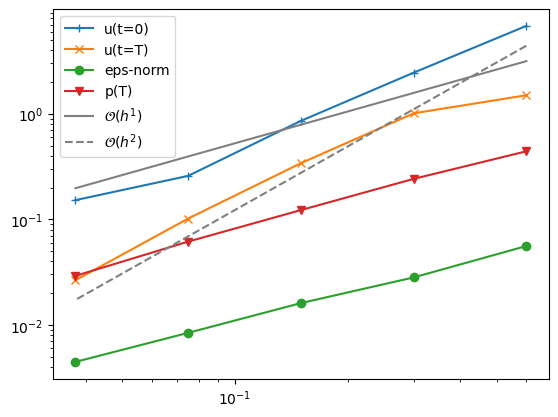

In [30]:
import matplotlib.pyplot as plt
hm = [0.6,0.3,0.15,0.075,0.0375]
Ns = [1,2,4,8,16]
hnp = np.array(hm)
plt.loglog(hnp, l2_vel_initial_time,label="u(t=0)",marker= '+' ) 
plt.loglog(hnp, l2_vel_final_time,label="u(t=T)",marker= 'x' ) 
plt.loglog(hnp, delta_norm,label="eps-norm",marker= 'o' ) 
plt.loglog(hnp,l2_p_final_time,label="p(T)",marker= 'v' ) 
plt.loglog(hnp,5.25*hnp**1,label="$\mathcal{O}(h^{1})$",color='gray')
plt.loglog(hnp,12.25*hnp**2,label="$\mathcal{O}(h^{2})$",color='gray',linestyle='dashed')
plt.legend()
plt.show()

In [31]:
# gamma1 = 0, gamma0 = 1e-2
l2_vel_initial_time_nostab = [ 17.177253620318748  ,7.583869118505473,3.2619031192130943,0.875585174189847, 0.38420570224939027]
delta_norm_nostab = [0.15515270530382008,0.023517796874833595,0.01594558459327258,0.00839172882314557,0.004427410053035475 ] 

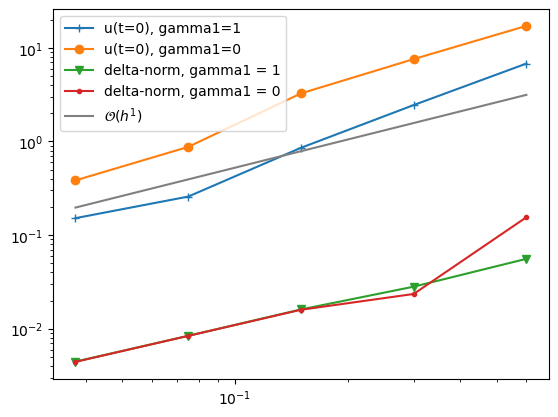

In [32]:
hnp = np.array(hm)
plt.loglog(hnp, l2_vel_initial_time,label="u(t=0), gamma1=1",marker= '+' ) 
plt.loglog(hnp, l2_vel_initial_time_nostab,label="u(t=0), gamma1=0",marker= 'o' ) 
plt.loglog(hnp, delta_norm,label="delta-norm, gamma1 = 1",marker= 'v' ) 
plt.loglog(hnp, delta_norm_nostab,label="delta-norm, gamma1 = 0",marker= '.' ) 
plt.loglog(hnp,5.25*hnp**1,label="$\mathcal{O}(h^{1})$",color='gray')
plt.legend()
plt.show()